<a href="https://colab.research.google.com/github/satyajitghana/TSAI-DeepNLP-END2.0/blob/main/11_Attention_Advanced/Attention_Advanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip3 install git+https://github.com/extensive-nlp/ttc_nlp --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 76 kB 3.7 MB/s 
     |████████████████████████████████| 22.3 MB 1.7 MB/s 
     |████████████████████████████████| 813 kB 62.5 MB/s 
     |████████████████████████████████| 6.4 MB 51.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 74 kB 3.8 MB/s 
     |████████████████████████████████| 234 kB 74.7 MB/s 
     |████████████████████████████████| 112 kB 57.3 MB/s 
     |████████████████████████████████| 636 kB 43.9 MB/s 
     |████████████████████████████████| 10.6 MB 46.0 MB/s 
     |████████████████████████████████| 829 kB 30.2 MB/s 
     |████████████████████████████████| 118 kB 69.0 MB/s 
     |████████████████████████████████| 1.3 MB 43.2 MB/s 
     |████████████████████████████████| 42 kB 1.9 MB/s 

In [1]:
from ttctext.datamodules.torch_translate import TorchLanguageData

Create the dataset

In [11]:
datamodule = TorchLanguageData(
    lang_file='eng-fra',
    reverse=True,
    batch_size=1
)

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4347
eng 2805


`setup` will split the dataset into train and test

In [12]:
datamodule.setup()

splitting dataset into train and test"


train loader

In [13]:
train_loader = datamodule.train_dataloader()

example batch of data, with `batch_size=1`

In [14]:
batch = next(iter(train_loader))

In [15]:
src_text, tgt_text, raw_src, raw_tgt = batch

In [183]:
print(
    f'Source Text: {src_text[0]}\t\t'
    f'Raw Source Text: {raw_src[0]}\n'
    f'Target Text: {tgt_text[0]}\t\t\t'
    f'Raw Target Text: {raw_tgt[0]}'
)

Source Text: tensor([ 13,  16, 463,   4,   3])		Raw Source Text: tu es impatiente .
Target Text: tensor([  7,   6, 413,   4,   3])			Raw Target Text: you re impatient .


## Model & Training Config

In [184]:
torch_dataset = datamodule

very useful, will be using it everywhere

In [185]:
from omegaconf import OmegaConf

In [186]:
hparams = OmegaConf.create({
    'input_dim': torch_dataset.input_lang.n_words,
    'hidden_size': 64,
    'output_dim': torch_dataset.output_lang.n_words,
    'max_length': 10,
    'swap_langs': True,
    'teacher_forcing_ratio': 0.5,
    'dropout': 0.1,
    'enc_lr': 1e-2,
    'dec_lr': 1e-2,
    'epochs': 5,
})

In [187]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Encoder

In [188]:
import torch.nn as nn
import torch

In [189]:
enc_embedding = nn.Embedding(
    hparams.input_dim,
    hparams.hidden_size
)
enc_embedding

Embedding(4347, 64)

In [190]:
enc_lstm = nn.LSTM(
    hparams.hidden_size,
    hparams.hidden_size,
    num_layers=1
)
enc_lstm

LSTM(64, 64)

In [191]:
input_lang_itos = torch_dataset.input_lang.get_itos()
target_lang_itos = torch_dataset.output_lang.get_itos()
input_lang_stoi = torch_dataset.input_lang.get_stoi()
target_lang_stoi = torch_dataset.output_lang.get_stoi()

In [192]:
f'The encoder will take the input sentence {src_text[0]} = {" ".join(input_lang_itos[x] for x in src_text[0])}'

'The encoder will take the input sentence tensor([ 13,  16, 463,   4,   3]) = tu es impatiente . <eos>'

In [193]:
enc_encoder_hidden = torch.zeros(1, 1, hparams.hidden_size), torch.zeros(1, 1, hparams.hidden_size)
enc_encoder_hidden[0].shape, enc_encoder_hidden[1].shape

(torch.Size([1, 1, 64]), torch.Size([1, 1, 64]))

In [194]:
# forward pass
seq_len = len(src_text[0])
embedded = enc_embedding(src_text[0]).view(seq_len, 1, -1)
enc_output, enc_hidden = enc_lstm(embedded, enc_encoder_hidden)

Note `enc_output` and `enc_hidden` will later be used by the decoder !

In [195]:
print(
    f'since our sentence has {len(src_text[0])} words, the number of tensors in enc_output is {enc_output.shape[0]}'
)

since our sentence has 5 words, the number of tensors in enc_output is 5


In [196]:
print(
    f'embedding: {embedded.shape}\nenc_output: {enc_output.shape}\nenc_hidden: {enc_hidden[0].shape, enc_hidden[1].shape}'
)

embedding: torch.Size([5, 1, 64])
enc_output: torch.Size([5, 1, 64])
enc_hidden: (torch.Size([1, 1, 64]), torch.Size([1, 1, 64]))


In [197]:
print(
    f'encoding for the word \'{input_lang_itos[src_text[0, 0]]}\' =>\n\n{enc_output[0]}'
)

encoding for the word 'tu' =>

tensor([[-0.0543,  0.0638, -0.1975, -0.1677, -0.0539, -0.0799, -0.0503,  0.0007,
         -0.1526,  0.0269,  0.1492,  0.2136,  0.0022, -0.0716,  0.0493,  0.0884,
          0.2390, -0.1747,  0.0222,  0.1018,  0.0792, -0.1830,  0.2660, -0.1601,
         -0.0031,  0.2112,  0.1274, -0.2266,  0.1665, -0.0918,  0.1431, -0.1941,
          0.1174, -0.1755,  0.2341, -0.1604, -0.0336, -0.0107, -0.0823,  0.2096,
         -0.1492,  0.0024, -0.2048, -0.2197, -0.0225, -0.0126,  0.1423, -0.0376,
          0.0351, -0.0735,  0.1298,  0.0437,  0.1812, -0.1990, -0.0230, -0.1988,
         -0.0519, -0.0607, -0.0144,  0.0720, -0.2157, -0.0570,  0.0637, -0.0687]],
       grad_fn=<SelectBackward>)


In [198]:
print(
    f'encoding for the word \'{input_lang_itos[src_text[0, 1]]}\' =>\n\n{enc_output[1]}'
)

encoding for the word 'es' =>

tensor([[ 0.0052, -0.1731, -0.2374, -0.0742, -0.1043, -0.0528, -0.0789,  0.0948,
         -0.1553, -0.1581,  0.3061,  0.0233, -0.0263, -0.1190,  0.2288,  0.3443,
          0.3691, -0.0884, -0.1495,  0.0013, -0.0716,  0.0549,  0.2131, -0.0852,
         -0.1066,  0.2260,  0.0553, -0.0925,  0.2297, -0.0972,  0.2397, -0.0222,
          0.0623, -0.3111,  0.2283, -0.1766,  0.0787, -0.0744, -0.0616,  0.0231,
         -0.0838,  0.0849, -0.4161,  0.0202, -0.1292, -0.0138,  0.0784,  0.0334,
         -0.1377, -0.0678,  0.0150,  0.1796, -0.0396,  0.1356,  0.0032, -0.0631,
          0.0989,  0.0350, -0.2848, -0.0165, -0.1672, -0.0179,  0.1378,  0.0915]],
       grad_fn=<SelectBackward>)


In [199]:
print(
    f'encoding for the word \'{input_lang_itos[src_text[0, 2]]}\' =>\n\n{enc_output[2]}'
)

encoding for the word 'impatiente' =>

tensor([[ 0.0732, -0.1036, -0.1111, -0.0589, -0.0526, -0.0549, -0.1882,  0.2312,
          0.0089, -0.1297, -0.0507, -0.1168, -0.0353,  0.0075,  0.0738,  0.1092,
          0.0566,  0.0912, -0.2511, -0.0793, -0.0123,  0.1230,  0.1665, -0.0725,
         -0.0762,  0.1660, -0.1273,  0.0871,  0.2491,  0.0638,  0.2093,  0.0893,
          0.1419, -0.2067,  0.0119, -0.1068,  0.1178,  0.0655, -0.0208, -0.0647,
         -0.1147, -0.0500, -0.0150, -0.0616, -0.2934, -0.1099, -0.2117,  0.1308,
         -0.1164, -0.0382,  0.1587,  0.1247, -0.1988,  0.1069,  0.0867, -0.0014,
          0.0079, -0.0263, -0.1672,  0.0169, -0.0829,  0.0871,  0.0611,  0.0820]],
       grad_fn=<SelectBackward>)


and so on every word is now encoded

## Decoder w/ Attention

> Luong et al. model

The Decoder parameters

In [236]:
dec_embedding = nn.Embedding(
    hparams.output_dim,
    hparams.hidden_size
)
dec_embedding

Embedding(2805, 64)

In [237]:
dec_lstm = nn.LSTM(
    hparams.hidden_size * 2,
    hparams.hidden_size, 1,
)
dec_lstm

LSTM(128, 64)

In [238]:
dec_out = nn.Linear(
    hparams.hidden_size * 2, hparams.output_dim
)
dec_out

Linear(in_features=128, out_features=2805, bias=True)

This is the attention part

In [239]:
luong_attn = nn.Linear(
    hparams.hidden_size, hparams.hidden_size
)
luong_attn

Linear(in_features=64, out_features=64, bias=True)

In [240]:
from ttctext.datamodules.torch_translate import SOS_token, EOS_token, PAD_token

In [241]:
decoder_input = torch.tensor([SOS_token]).unsqueeze(0) # SOS is the first word to the decoder
decoder_context = torch.zeros(1, hparams.hidden_size)
decoder_hidden = enc_encoder_hidden # Use last hidden state from encoder to start decoder

In [242]:
print(
    f'decoder_input:\t\t{decoder_input.shape}\ndecoder_context:\t{decoder_context.shape}\ndecoder_hidden:\t\t{decoder_hidden[0].shape, decoder_hidden[1].shape}'
)

decoder_input:		torch.Size([1, 1])
decoder_context:	torch.Size([1, 64])
decoder_hidden:		(torch.Size([1, 1, 64]), torch.Size([1, 1, 64]))


In [243]:
dec_word_input = decoder_input

# Get the embedding of the current input word (last output word)
dec_word_embedded = dec_embedding(dec_word_input).view(1, 1, -1) # S=1 x B x N
f'dec_word_embedded: {dec_word_embedded.shape}'

'dec_word_embedded: torch.Size([1, 1, 64])'

In [244]:
last_context = decoder_context
last_hidden = decoder_hidden

# Combine embedded input word and last context, run through RNN
dec_rnn_input = torch.cat((dec_word_embedded, last_context.unsqueeze(0)), dim=2)
dec_rnn_output, dec_rnn_hidden = dec_lstm(dec_rnn_input, last_hidden)

In [245]:
print(
    f'dec_rnn_input:\t\t{dec_rnn_input.shape}\ndec_rnn_output:\t\t{dec_rnn_output.shape}\ndec_rnn_hidden:\t\t{dec_rnn_hidden[0].shape, dec_rnn_hidden[0].shape}'
)

dec_rnn_input:		torch.Size([1, 1, 128])
dec_rnn_output:		torch.Size([1, 1, 64])
dec_rnn_hidden:		(torch.Size([1, 1, 64]), torch.Size([1, 1, 64]))


In [246]:
print(
    f'dec_rnn_output: {dec_rnn_output.shape} value =>\n\n{dec_rnn_output}'
)

dec_rnn_output: torch.Size([1, 1, 64]) value =>

tensor([[[ 2.4784e-02,  1.3236e-01,  2.8387e-02,  3.1887e-03,  1.3423e-01,
          -8.7927e-02,  1.5511e-01,  2.8784e-02,  1.0580e-01, -1.4575e-01,
          -4.3383e-03, -5.2812e-02,  1.7754e-01, -3.1593e-02,  6.7075e-02,
           7.7494e-02,  4.9320e-02,  1.7713e-01, -2.0790e-01, -5.0475e-02,
          -5.8649e-02,  4.6692e-02, -3.1964e-02, -1.3329e-01, -9.9950e-02,
          -9.4949e-02,  2.1983e-02,  1.2766e-01,  3.3407e-02,  1.2375e-02,
          -9.7627e-02,  8.2564e-05,  4.0589e-02, -5.0377e-02, -6.5772e-02,
           2.8655e-02, -1.1418e-01,  5.5525e-02,  1.6390e-01,  3.2977e-02,
           1.3898e-02,  4.4744e-02, -5.5388e-02, -5.9081e-02,  2.2567e-02,
          -1.6297e-01,  9.2167e-02, -1.4468e-01,  5.4815e-02, -8.2351e-02,
          -4.3525e-02,  6.9047e-02,  5.4019e-02, -1.1496e-01, -1.9732e-01,
           5.2014e-02,  2.2706e-01,  6.1765e-02,  1.0778e-01,  7.5064e-02,
           1.1164e-01, -4.1908e-02, -7.5117e-02,  1

Calculate attention from current RNN state

In [247]:
seq_len = len(enc_output)

# Create variable to store attention energies
attn_energies = torch.zeros(seq_len) # B x 1 x S

attn_hidden = dec_rnn_output.squeeze(0)

# Calculate energies for each encoder output
for i in range(seq_len):
    energy = luong_attn(enc_output[i])
    energy = attn_hidden.view(-1).dot(energy.view(-1))
    
    print(f'energy for {i}th word: {energy}')

    attn_energies[i] = energy

energy for 0th word: 0.013496480882167816
energy for 1th word: -0.019721370190382004
energy for 2th word: 0.04026033729314804
energy for 3th word: 0.11657365411520004
energy for 4th word: 0.05412563309073448


In [248]:
print(
    f'attention energies: {attn_energies.shape} values =>\n\n{attn_energies}',
)

attention energies: torch.Size([5]) values =>

tensor([ 0.0135, -0.0197,  0.0403,  0.1166,  0.0541], grad_fn=<CopySlices>)


In [249]:
import torch.nn.functional as F

In [250]:
# Normalize energies to weights in range 0 to 1, resize to 1 x 1 x seq_len
dec_attn_weights =  F.softmax(attn_energies, dim=0).unsqueeze(0).unsqueeze(0)

In [251]:
dec_attn_weights.sum()

tensor(1., grad_fn=<SumBackward0>)

In [252]:
print(
    f'attention weights: {dec_attn_weights.shape} values =>\n\n{dec_attn_weights}'
)

attention weights: torch.Size([1, 1, 5]) values =>

tensor([[[0.1944, 0.1880, 0.1997, 0.2155, 0.2024]]],
       grad_fn=<UnsqueezeBackward0>)


In [253]:
# apply to encoder outputs
dec_context_new = dec_attn_weights.bmm(enc_output.transpose(0, 1)) # B x 1 x N

In [254]:
print(
    f'dec_context_new: {dec_context_new.shape} values =>\n\n{dec_context_new}'
)

dec_context_new: torch.Size([1, 1, 64]) values =>

tensor([[[ 0.0873, -0.0190, -0.0559, -0.0386, -0.0353,  0.0400, -0.0116,
           0.1641, -0.0525, -0.0474,  0.0651,  0.0297, -0.0100, -0.1076,
           0.0932,  0.1184,  0.1446, -0.0358, -0.2018,  0.0410, -0.0010,
          -0.0116,  0.1718, -0.0905, -0.0948,  0.2211, -0.1088, -0.0856,
           0.0962, -0.0698,  0.0966, -0.0301,  0.1399, -0.1744,  0.0716,
          -0.1258,  0.0235, -0.0409, -0.0293,  0.0687, -0.0779,  0.0336,
          -0.1106,  0.0323, -0.1402, -0.0324, -0.0821,  0.1166, -0.1192,
           0.0371,  0.1582,  0.0321, -0.1342,  0.1206,  0.0797, -0.0553,
          -0.0261,  0.0474, -0.0550,  0.0025, -0.0787, -0.0014, -0.0070,
           0.0421]]], grad_fn=<BmmBackward0>)


In [255]:
# Final output layer (next word prediction) using the RNN hidden state and context vector
dec_rnn_output_new = dec_rnn_output.squeeze(0) # S=1 x B x N -> B x N
dec_context_new = dec_context_new.squeeze(1)       # B x S=1 x N -> B x N
dec_output_final = F.log_softmax(
    dec_out(torch.cat((dec_rnn_output_new, dec_context_new), dim=1)),
    dim=-1
)

In [256]:
torch.log(F.softmax(
    dec_out(torch.cat((dec_rnn_output_new, dec_context_new), dim=1)),
    dim=-1
)).sum()

tensor(-22277.1465, grad_fn=<SumBackward0>)

In [257]:
dec_output_final.sum()

tensor(-22277.1465, grad_fn=<SumBackward0>)

In [258]:
print(
    f'size after concatenating dec_context and dec_rnn_output: {torch.cat((dec_rnn_output_new, dec_context_new), dim=1).shape}'
)

size after concatenating dec_context and dec_rnn_output: torch.Size([1, 128])


After applying the final FC layer of decoder output

In [259]:
print(
    f'dec_rnn_output_new: {dec_rnn_output_new.shape} values =>\n\n{dec_rnn_output_new}'
)

dec_rnn_output_new: torch.Size([1, 64]) values =>

tensor([[ 2.4784e-02,  1.3236e-01,  2.8387e-02,  3.1887e-03,  1.3423e-01,
         -8.7927e-02,  1.5511e-01,  2.8784e-02,  1.0580e-01, -1.4575e-01,
         -4.3383e-03, -5.2812e-02,  1.7754e-01, -3.1593e-02,  6.7075e-02,
          7.7494e-02,  4.9320e-02,  1.7713e-01, -2.0790e-01, -5.0475e-02,
         -5.8649e-02,  4.6692e-02, -3.1964e-02, -1.3329e-01, -9.9950e-02,
         -9.4949e-02,  2.1983e-02,  1.2766e-01,  3.3407e-02,  1.2375e-02,
         -9.7627e-02,  8.2564e-05,  4.0589e-02, -5.0377e-02, -6.5772e-02,
          2.8655e-02, -1.1418e-01,  5.5525e-02,  1.6390e-01,  3.2977e-02,
          1.3898e-02,  4.4744e-02, -5.5388e-02, -5.9081e-02,  2.2567e-02,
         -1.6297e-01,  9.2167e-02, -1.4468e-01,  5.4815e-02, -8.2351e-02,
         -4.3525e-02,  6.9047e-02,  5.4019e-02, -1.1496e-01, -1.9732e-01,
          5.2014e-02,  2.2706e-01,  6.1765e-02,  1.0778e-01,  7.5064e-02,
          1.1164e-01, -4.1908e-02, -7.5117e-02,  1.3715e-02]]

In [260]:
print(
    f'dec_context_new: {dec_context_new.shape} values =>\n\n{dec_context_new}'
)

dec_context_new: torch.Size([1, 64]) values =>

tensor([[ 0.0873, -0.0190, -0.0559, -0.0386, -0.0353,  0.0400, -0.0116,  0.1641,
         -0.0525, -0.0474,  0.0651,  0.0297, -0.0100, -0.1076,  0.0932,  0.1184,
          0.1446, -0.0358, -0.2018,  0.0410, -0.0010, -0.0116,  0.1718, -0.0905,
         -0.0948,  0.2211, -0.1088, -0.0856,  0.0962, -0.0698,  0.0966, -0.0301,
          0.1399, -0.1744,  0.0716, -0.1258,  0.0235, -0.0409, -0.0293,  0.0687,
         -0.0779,  0.0336, -0.1106,  0.0323, -0.1402, -0.0324, -0.0821,  0.1166,
         -0.1192,  0.0371,  0.1582,  0.0321, -0.1342,  0.1206,  0.0797, -0.0553,
         -0.0261,  0.0474, -0.0550,  0.0025, -0.0787, -0.0014, -0.0070,  0.0421]],
       grad_fn=<SqueezeBackward1>)


In [261]:
print(
    f'dec_output_final: {dec_output_final.shape} values =>\n\n{dec_output_final}'
)

dec_output_final: torch.Size([1, 2805]) values =>

tensor([[-7.8912, -7.8641, -7.9288,  ..., -7.8772, -7.9572, -8.1186]],
       grad_fn=<LogSoftmaxBackward>)


In [262]:
dec_topv, dec_topi = dec_output_final.data.topk(1)
ni = dec_topi[0, 0]

In [263]:
dec_topv, dec_topi

(tensor([[-7.6851]]), tensor([[2579]]))

In [264]:
ni

tensor(2579)

In [265]:
len(target_lang_itos)

2805

In [266]:
print(
    f'predicted word: {target_lang_itos[ni]}'
)

predicted word: samples


Now we set the `decoder_input` to `di` and this loop goes on

In [267]:
decoder_input = torch.tensor([SOS_token]).unsqueeze(0) # SOS is the first word to the decoder
decoder_context = torch.zeros(1, hparams.hidden_size)
decoder_hidden_test = enc_encoder_hidden # Use last hidden state from encoder to start decoder

In [268]:
last_context = decoder_context
last_hidden = decoder_hidden

In [269]:
i = 0

dec_word_input = decoder_input

print(f'decoder word input: {dec_word_input} value: {target_lang_itos[dec_word_input[0, 0]]}')

dec_word_embedded = dec_embedding(dec_word_input).view(1, 1, -1)

dec_rnn_input = torch.cat((dec_word_embedded, last_context.unsqueeze(0)), dim=2)
dec_rnn_output, dec_rnn_hidden_new = dec_lstm(dec_rnn_input, last_hidden)

# --- attn
seq_len = len(enc_output)
attn_energies = torch.zeros(seq_len)
attn_hidden = dec_rnn_output.squeeze(0).squeeze(0)
for i in range(seq_len):
    energy = luong_attn(enc_output[i]).squeeze(0)
    energy = attn_hidden.dot(energy)
    attn_energies[i] = energy
# --- attn

dec_attn_weights = F.softmax(attn_energies, dim=0).unsqueeze(0).unsqueeze(0)

print(f'attentions: {dec_attn_weights[0, 0].detach().numpy()}')

dec_context_new = dec_attn_weights.bmm(enc_output.transpose(0, 1))

dec_rnn_output_new = dec_rnn_output.squeeze(0) # S=1 x B x N -> B x N
dec_context_new = dec_context_new.squeeze(1)       # B x S=1 x N -> B x N
dec_output_final = F.log_softmax(
    dec_out(torch.cat((dec_rnn_output_new, dec_context_new), 1)),
    dim=-1
)

dec_topv, dec_topi = dec_output_final.data.topk(1)
ni = dec_topi[0, 0]

print(
    f'predicted word: {target_lang_itos[ni]}'
)

decoder_input = torch.tensor([ni]).unsqueeze(0)

last_context = dec_context_new
last_hidden = dec_rnn_hidden_new

print('\n')

decoder word input: tensor([[2]]) value: <sos>
attentions: [0.1943825  0.18803161 0.19965519 0.21548797 0.20244274]
predicted word: samples




In [270]:
last_context = decoder_context
last_hidden = decoder_hidden

In [271]:
i = 1

dec_word_input = decoder_input

print(f'decoder word input: {dec_word_input} value: {target_lang_itos[dec_word_input[0, 0]]}')

dec_word_embedded = dec_embedding(dec_word_input).view(1, 1, -1)

dec_rnn_input = torch.cat((dec_word_embedded, last_context.unsqueeze(0)), dim=2)
dec_rnn_output, dec_rnn_hidden_new = dec_lstm(dec_rnn_input, last_hidden)

# --- attn
seq_len = len(enc_output)
attn_energies = torch.zeros(seq_len)
attn_hidden = dec_rnn_output.squeeze(0).squeeze(0)
for i in range(seq_len):
    energy = luong_attn(enc_output[i]).squeeze(0)
    energy = attn_hidden.dot(energy)
    attn_energies[i] = energy
# --- attn

dec_attn_weights = F.softmax(attn_energies, dim=0).unsqueeze(0).unsqueeze(0)

print(f'attentions: {dec_attn_weights[0, 0].detach().numpy()}')

dec_context_new = dec_attn_weights.bmm(enc_output.transpose(0, 1))

dec_rnn_output_new = dec_rnn_output.squeeze(0) # S=1 x B x N -> B x N
dec_context_new = dec_context_new.squeeze(1)       # B x S=1 x N -> B x N
dec_output_final = F.log_softmax(
    dec_out(torch.cat((dec_rnn_output_new, dec_context_new), 1)),
    dim=-1
)

dec_topv, dec_topi = dec_output_final.data.topk(1)
ni = dec_topi[0, 0]

print(
    f'predicted word: {target_lang_itos[ni]}'
)

decoder_input = torch.tensor([ni]).unsqueeze(0)

last_context = dec_context_new
last_hidden = dec_rnn_hidden_new

print('\n')

decoder word input: tensor([[2579]]) value: samples
attentions: [0.21555178 0.19511788 0.20333609 0.19306885 0.19292536]
predicted word: shot




In [272]:
decoder_input = torch.tensor([SOS_token]).unsqueeze(0) # SOS is the first word to the decoder
decoder_context = torch.zeros(1, hparams.hidden_size)
decoder_hidden_test = enc_encoder_hidden # Use last hidden state from encoder to start decoder

last_context = decoder_context
last_hidden = decoder_hidden

for i in range(hparams.max_length):

    dec_word_input = decoder_input

    print(f'decoder word input: {dec_word_input} value: {target_lang_itos[dec_word_input[0, 0]]}')

    dec_word_embedded = dec_embedding(dec_word_input).view(1, 1, -1)

    dec_rnn_input = torch.cat((dec_word_embedded, last_context.unsqueeze(0)), dim=2)
    dec_rnn_output, dec_rnn_hidden_new = dec_lstm(dec_rnn_input, last_hidden)

    # --- attn
    seq_len = len(enc_output)
    attn_energies = torch.zeros(seq_len)
    attn_hidden = dec_rnn_output.squeeze(0).squeeze(0)
    for i in range(seq_len):
        energy = luong_attn(enc_output[i]).squeeze(0)
        energy = attn_hidden.dot(energy)
        attn_energies[i] = energy
    # --- attn

    dec_attn_weights = F.softmax(attn_energies, dim=0).unsqueeze(0).unsqueeze(0)

    print(f'attentions: {dec_attn_weights[0, 0].detach().numpy()}')

    dec_context_new = dec_attn_weights.bmm(enc_output.transpose(0, 1))

    dec_rnn_output_new = dec_rnn_output.squeeze(0) # S=1 x B x N -> B x N
    dec_context_new = dec_context_new.squeeze(1)       # B x S=1 x N -> B x N
    dec_output_final = F.log_softmax(
        dec_out(torch.cat((dec_rnn_output_new, dec_context_new), 1)),
        dim=-1
    )

    dec_topv, dec_topi = dec_output_final.data.topk(1)
    ni = dec_topi[0, 0]

    print(
        f'predicted word: {target_lang_itos[ni]}'
    )

    decoder_input = torch.tensor([ni]).unsqueeze(0)

    if ni == EOS_token: break

    last_context = dec_context_new
    last_hidden = dec_rnn_hidden_new

    print('\n')

decoder word input: tensor([[2]]) value: <sos>
attentions: [0.1943825  0.18803161 0.19965519 0.21548797 0.20244274]
predicted word: samples


decoder word input: tensor([[2579]]) value: samples
attentions: [0.21375291 0.18870133 0.19963732 0.20372882 0.19417965]
predicted word: samples


decoder word input: tensor([[2579]]) value: samples
attentions: [0.22272563 0.19198284 0.19868419 0.19550982 0.19109744]
predicted word: shot


decoder word input: tensor([[1720]]) value: shot
attentions: [0.22027186 0.19475831 0.18840393 0.20425858 0.1923073 ]
predicted word: drunk


decoder word input: tensor([[164]]) value: drunk
attentions: [0.23428832 0.19531    0.18941379 0.20000423 0.18098357]
predicted word: spokesperson


decoder word input: tensor([[1744]]) value: spokesperson
attentions: [0.20320848 0.20838186 0.20744191 0.18297379 0.1979939 ]
predicted word: awfully


decoder word input: tensor([[1365]]) value: awfully
attentions: [0.21121682 0.1958446  0.20257479 0.18374462 0.20661913]
pre

## Putting it all together

In [146]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import pytorch_lightning as pl

import random

from ttctext.datamodules.torch_translate import tensorFromSentence

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, method='lstm', n_layers=1):
        super(EncoderRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.method = method

        assert method in ['lstm', 'gru'], f"'lstm' and 'gru' only supported"
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        if self.method == 'lstm':
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers)
        elif self.method == 'gru':
            self.rnn = nn.GRU(hidden_size, hidden_size, n_layers)
        
    def forward(self, word_inputs, hidden):
        # Note: we run this all at once (over the whole input sequence)
        seq_len = len(word_inputs)
        embedded = self.embedding(word_inputs).view(seq_len, 1, -1)

        # print(embedded.shape, hidden[0].shape, hidden[1].shape)

        output, hidden = self.rnn(embedded, hidden)
        return output, hidden

    def init_hidden(self, device):
        if self.method == 'lstm':
            hidden = torch.zeros(self.n_layers, 1, self.hidden_size, device=device), torch.zeros(self.n_layers, 1, self.hidden_size, device=device)
        elif self.method == 'gru':
            hidden = torch.zeros(self.n_layers, 1, self.hidden_size, device=device)
        return hidden


class LuongAttn(nn.Module):
    def __init__(self, hidden_size):
        super(LuongAttn, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.attn = nn.Linear(self.hidden_size, self.hidden_size)

    def forward(self, hidden, encoder_outputs, device):
        seq_len = len(encoder_outputs)

        # Create variable to store attention energies
        attn_energies = torch.zeros(seq_len, device=device) # B x 1 x S

        # Calculate energies for each encoder output
        for i in range(seq_len):
            attn_energies[i] = self.score(hidden, encoder_outputs[i])

        # Normalize energies to weights in range 0 to 1, resize to 1 x 1 x seq_len
        return F.softmax(attn_energies, dim=-1).unsqueeze(0).unsqueeze(0)
    
    def score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        energy = hidden.view(-1).dot(energy.view(-1))
        return energy


class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, method='lstm', n_layers=1, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        
        # Keep parameters for reference
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.method = method

        assert method in ['lstm', 'gru'], f"'lstm' and 'gru' only supported"

        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)

        if self.method == 'lstm':
            self.rnn = nn.LSTM(hidden_size * 2, hidden_size, n_layers, dropout=dropout_p)
        elif self.method == 'gru':
            self.rnn = nn.GRU(hidden_size * 2, hidden_size, n_layers, dropout=dropout_p)
        
        self.out = nn.Linear(hidden_size * 2, output_size)
        
        # Choose attention model
        self.attn = LuongAttn(hidden_size)
    
    def forward(self, word_input, last_context, last_hidden, encoder_outputs, device):
        # Note: we run this one step at a time
        
        # Get the embedding of the current input word (last output word)
        word_embedded = self.embedding(word_input).view(1, 1, -1) # S=1 x B x N
        
        # Combine embedded input word and last context, run through RNN
        rnn_input = torch.cat((word_embedded, last_context.unsqueeze(0)), dim=2)
        rnn_output, hidden = self.rnn(rnn_input, last_hidden)

        # Calculate attention from current RNN state and all encoder outputs; apply to encoder outputs
        attn_weights = self.attn(rnn_output.squeeze(0), encoder_outputs, device)
        # print(encoder_outputs.device, attn_weights.device)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x 1 x N
        
        # Final output layer (next word prediction) using the RNN hidden state and context vector
        rnn_output = rnn_output.squeeze(0) # S=1 x B x N -> B x N
        context = context.squeeze(1)       # B x S=1 x N -> B x N
        output = F.log_softmax(
            self.out(
                torch.cat(
                    (rnn_output, context),
                    dim=1
                )
            ),
            dim=-1
        )

        # print(output.shape)
        
        # Return final output, hidden state, and attention weights (for visualization)
        return output, context, hidden, attn_weights


class TorchTranslateModel(pl.LightningModule):

    def __init__(self, hparams, *args, **kwargs):
        super().__init__()

        self.save_hyperparameters(hparams)

        self.automatic_optimization = False

        self.encoder = EncoderRNN(self.hparams.input_dim, self.hparams.hidden_size, n_layers=self.hparams.n_layers, method=self.hparams.method)
        self.decoder = AttnDecoderRNN(self.hparams.hidden_size, self.hparams.output_dim, n_layers=self.hparams.n_layers, method=self.hparams.method, dropout_p=self.hparams.dropout)

        self.criterion = nn.NLLLoss()


    def forward(self, input_tensor, target_tensor):

        loss = 0 # Added onto for each word

        input_length = input_tensor.size()[0]
        target_length = target_tensor.size()[0]

        # Run words through encoder
        encoder_hidden = self.encoder.init_hidden(self.device)
        encoder_outputs, encoder_hidden = self.encoder(input_tensor, encoder_hidden)
        
        # Prepare input and output variables
        decoder_input = torch.tensor([[SOS_token]], device=self.device)
        decoder_context = torch.zeros(1, self.decoder.hidden_size, device=self.device)
        decoder_hidden = encoder_hidden # Use last hidden state from encoder to start decoder

        # Choose whether to use teacher forcing
        use_teacher_forcing = random.random() < self.hparams.teacher_forcing_ratio

        if use_teacher_forcing:
            # Teacher forcing: Use the ground-truth target as the next input
            for di in range(target_length):
                decoder_output, decoder_context, decoder_hidden, decoder_attention = self.decoder(
                    decoder_input, decoder_context, decoder_hidden, encoder_outputs, self.device
                )
                loss += self.criterion(decoder_output, target_tensor[di])
                decoder_input = target_tensor[di] # Next target is next input

        else:
            # Without teacher forcing: use network's own prediction as the next input
            for di in range(target_length):
                decoder_output, decoder_context, decoder_hidden, decoder_attention = self.decoder(
                    decoder_input, decoder_context, decoder_hidden, encoder_outputs, self.device
                )
                # print(decoder_output.shape, target_tensor[di].shape)
                loss += self.criterion(decoder_output, target_tensor[di])
                
                # Get most likely word index (highest value) from output
                topv, topi = decoder_output.data.topk(1)
                ni = topi[0][0]
                
                decoder_input = torch.tensor([[ni]], device=self.device) # Chosen word is next input

                # Stop at end of sentence (not necessary when using known targets)
                if ni == EOS_token: break

        return loss, loss / target_length

    def shared_step(self, batch, batch_idx):
        src_tensor, tgt_tensor, raw_src, raw_tgt = batch

        if self.hparams.swap_langs:
            src_tensor, tgt_tensor = tgt_tensor, src_tensor
            raw_src, raw_tgt = raw_tgt, raw_src

        assert src_tensor.size(0) == 1, 'only batch_size==1 supported'
        assert tgt_tensor.size(0) == 1, 'only batch_size==1 supported'

        loss, loss_n = self(src_tensor.view(-1, 1), tgt_tensor.view(-1, 1))
        
        metric = {'loss': loss, 'loss_n': loss_n}

        return metric


    def training_step(self, batch, batch_idx):
        enc_opt, dec_opt = self.optimizers()
        enc_opt.zero_grad() ; dec_opt.zero_grad()

        metrics = self.shared_step(batch, batch_idx)

        self.manual_backward(metrics['loss'])

        # torch.nn.utils.clip_grad_norm_(self.encoder.parameters(), self.hparams.clip)
        # torch.nn.utils.clip_grad_norm_(self.decoder.parameters(), self.hparams.clip)

        enc_opt.step() ; dec_opt.step()

        log_metrics = {'train_loss': metrics['loss_n']}

        self.log_dict(log_metrics, prog_bar=True)

        return metrics


    def validation_step(self, batch, batch_idx):
        metrics = self.shared_step(batch, batch_idx)

        return metrics
    

    def validation_epoch_end(self, outputs):
        loss = torch.stack([x['loss_n'] for x in outputs]).mean()

        log_metrics = {'val_loss': loss}

        self.log_dict(log_metrics, prog_bar=True)

        return log_metrics


    def test_step(self, batch, batch_idx):
        return self.validation_step(batch, batch_idx)

    def test_epoch_end(self, outputs):
        accuracy = torch.stack([x['loss_n'] for x in outputs]).mean()

        self.log('hp_metric', accuracy)

        self.log_dict({'test_loss': accuracy}, prog_bar=True)


    def configure_optimizers(self):
        encoder_optimizer = optim.SGD(self.encoder.parameters(), lr=self.hparams.enc_lr)
        decoder_optimizer = optim.SGD(self.decoder.parameters(), lr=self.hparams.dec_lr)
        return encoder_optimizer, decoder_optimizer

    def evaluate(self, datamodule: TorchLanguageData, sentence: str):
        self.eval()

        input_lang, output_lang = datamodule.input_lang, datamodule.output_lang

        if self.hparams.swap_langs:
            input_lang, output_lang = output_lang, input_lang

        with torch.no_grad():
            input_tensor = tensorFromSentence(input_lang, sentence)

            input_length = input_tensor.size()[0]
            
            # Run through encoder
            encoder_hidden = self.encoder.init_hidden(self.device)
            encoder_outputs, encoder_hidden = self.encoder(input_tensor, encoder_hidden)

            # Create starting vectors for decoder
            decoder_input = torch.tensor([[SOS_token]], device=self.device) # SOS
            decoder_context = torch.zeros(1, self.decoder.hidden_size, device=self.device)

            decoder_hidden = encoder_hidden
            
            decoded_words = []
            decoder_attentions = torch.zeros(self.hparams.max_length, self.hparams.max_length, device=self.device)
            
            # Run through decoder
            for di in range(self.hparams.max_length):
                decoder_output, decoder_context, decoder_hidden, decoder_attention = self.decoder(
                    decoder_input, decoder_context, decoder_hidden, encoder_outputs, self.device
                )
                decoder_attentions[di,:decoder_attention.size(2)] += decoder_attention.squeeze(0).squeeze(0).cpu().data

                # Choose top word from output
                topv, topi = decoder_output.data.topk(1)
                ni = topi[0][0]
                if ni == EOS_token:
                    decoded_words.append('<EOS>')
                    break
                else:
                    decoded_words.append(output_lang.get_itos()[ni])
                    
                # Next input is chosen word
                decoder_input = torch.tensor([[ni]], device=self.device)
            
            return decoded_words, decoder_attentions[:di+1, :len(encoder_outputs)]

In [168]:
hparams = OmegaConf.create({
    'input_dim': torch_dataset.input_lang.n_words,
    'hidden_size': 384,
    'output_dim': torch_dataset.output_lang.n_words,
    'max_length': 10,
    'n_layers': 2,
    'method': 'lstm',
    'clip': 5.0,
    'swap_langs': False,
    'teacher_forcing_ratio': 0.5,
    'dropout': 0.1,
    'enc_lr': 1e-2,
    'dec_lr': 1e-2,
    'epochs': 8,
})

In [169]:
torch_model = TorchTranslateModel(hparams)

In [170]:
trainer = pl.Trainer(gpus=1, max_epochs=hparams.epochs)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [171]:
trainer.fit(torch_model, torch_dataset)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type           | Params
---------------------------------------------
0 | encoder   | EncoderRNN     | 4.0 M 
1 | decoder   | AttnDecoderRNN | 6.3 M 
2 | criterion | NLLLoss        | 0     
---------------------------------------------
10.4 M    Trainable params
0         Non-trainable params
10.4 M    Total params
41.488    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:897: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn('Detected KeyboardInterrupt, attempting graceful shutdown...')


In [172]:
def evalulate_randomly(model, dataset, n=10):
    for i in range(n):
        input_sentence, output_sentence = random.choice(dataset.train_pairs)
        if hparams.swap_langs:
            input_sentence, output_sentence = output_sentence, input_sentence
        print('>', input_sentence)
        print('=', output_sentence)
        output_words, attentions = model.evaluate(dataset, input_sentence)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [173]:
evalulate_randomly(torch_model, torch_dataset)

> elle est de mauvaise humeur .
= she is in a bad mood .
< she is in a mood . <EOS>

> je suis dure a cuire .
= i m tough .
< i m tough . <EOS>

> j etudie l economie a l universite .
= i m studying economics at university .
< i m studying the college . <EOS>

> je n en suis pas trop convaincu .
= i m not too convinced .
< i m not too too . <EOS>

> je suis ravie de t aider .
= i am glad to help you .
< i m glad to help you . <EOS>

> elle a tres peur des chiens .
= she s very afraid of dogs .
< she is very afraid of dogs . <EOS>

> il est fier d etre musicien .
= he is proud of being a musician .
< he s proud of a of . <EOS>

> c est le portrait crache de son pere .
= he is the image of his father .
< he is the for father father . <EOS>

> je suis juste paresseuse .
= i m just lazy .
< i m just . . <EOS>

> nous sommes en train de nous en charger .
= we re handling it .
< we re back . <EOS>



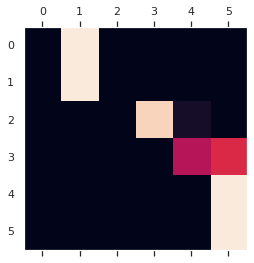

In [174]:
import matplotlib.pyplot as plt

output_words, attentions = torch_model.evaluate(torch_dataset, "je suis trop froid .")
plt.matshow(attentions.numpy())

In [175]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns
sns.set()
sns.set_style("dark")

def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(model, dataset, input_sentence):
    output_words, attentions = model.evaluate(dataset, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

input = je suis sur la paille et fatigue .
output = i m sure and are . <EOS>


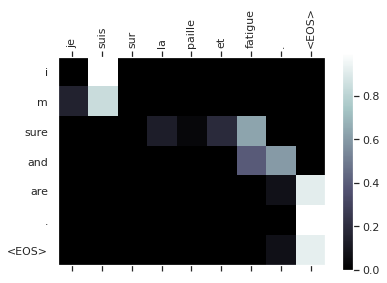

In [176]:
evaluateAndShowAttention(torch_model, torch_dataset, 'je suis sur la paille et fatigue .')

input = il trouve toujours a redire aux autres .
output = he is always always for fault . <EOS>


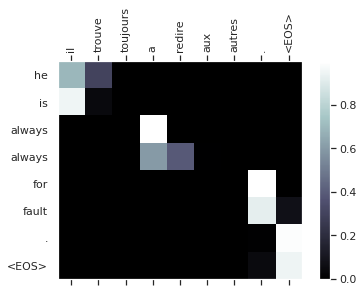

In [177]:
evaluateAndShowAttention(torch_model, torch_dataset, 'il trouve toujours a redire aux autres .')

input = c est un jeune directeur plein de talent .
output = he s a young young . . <EOS>


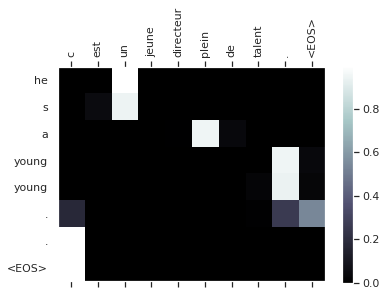

In [178]:
evaluateAndShowAttention(torch_model, torch_dataset, "c est un jeune directeur plein de talent .")

input = je ne crains pas de mourir .
output = i m not afraid to die . <EOS>


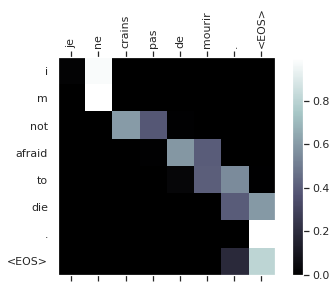

In [179]:
evaluateAndShowAttention(torch_model, torch_dataset, "je ne crains pas de mourir .")

## Tensorboard Logs

In [ ]:
! tensorboard dev upload --logdir lightning_logs \
    --name "END2 11_Attention_Advances - Satyajit" \
    --description "Experiments on Attention model on PyTorch's Language Dataset"


## Tensorboard Logs: https://tensorboard.dev/experiment/kwH5WKoQTOaJLhOc9oYy6Q/